In [3]:
import zipfile
import os

# Define the path to your zip file and the extraction folder
zip_file_path = 'amazon_alexa.zip'
extraction_folder = 'amazon_alexa_data'

# Create the extraction folder if it doesn't exist
os.makedirs(extraction_folder, exist_ok=True)

# Unzip the file into the 'data' folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_folder)
    print(f"Unzipped files to '{extraction_folder}'")


Unzipped files to 'amazon_alexa_data'


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
#Load the data

data = pd.read_csv(r"amazon_alexa_data/amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [10]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [11]:
#Column names
print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [12]:
#Check for null values

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [13]:
#Getting the record where 'verified_reviews' is null 

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback


In [14]:
#We will drop the null record

data.dropna(inplace=True)

In [15]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3150, 5)


In [16]:
#Getting the record where 'verified_reviews' is null 

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback


In [17]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [18]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [19]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
'length' column value : 65


In [20]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [21]:
len(data)

3150

In [22]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

#almost 70% of the reviews are 5 star 

Rating value count: 
5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64


In [23]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

# we are considering ratings 3,4,5 as positive anf 1,2 as negative , so these are two groups, we are not taking 3 as nutral
#bec 3 is very less and it will cause class imbalance.}

Rating value count - percentage distribution: 
5    72.57
4    14.44
1     5.11
3     4.83
2     3.05
Name: rating, dtype: float64


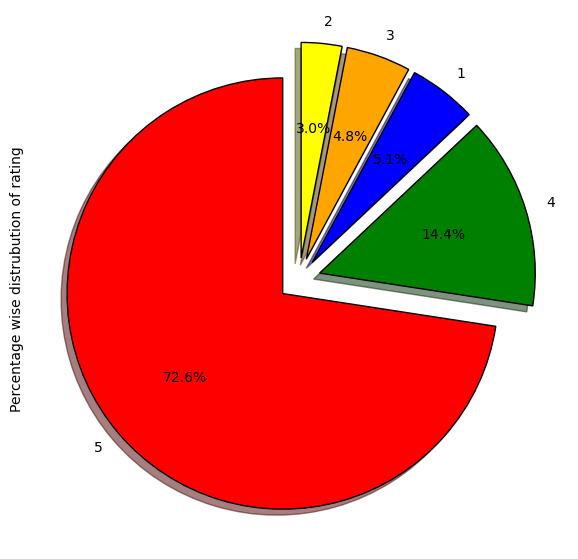

In [24]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

In [25]:
#Distinct values of 'feedback' and its count 
#original intution was that feeback=1 means that feedback was given and 0 means feeback wasnt given
print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
1    2893
0     257
Name: feedback, dtype: int64


In [26]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [27]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


In [28]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
1    91.84
0     8.16
Name: feedback, dtype: float64


<Axes: ylabel='Percentage wise distrubution of feedback'>

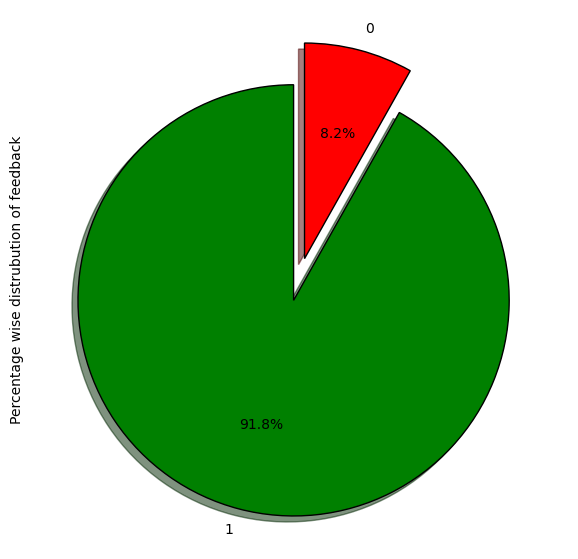

In [29]:
fig = plt.figure(figsize=(7,7))

colors = ('green', 'red')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

In [30]:
#Distinct values of 'variation' and its count 

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64


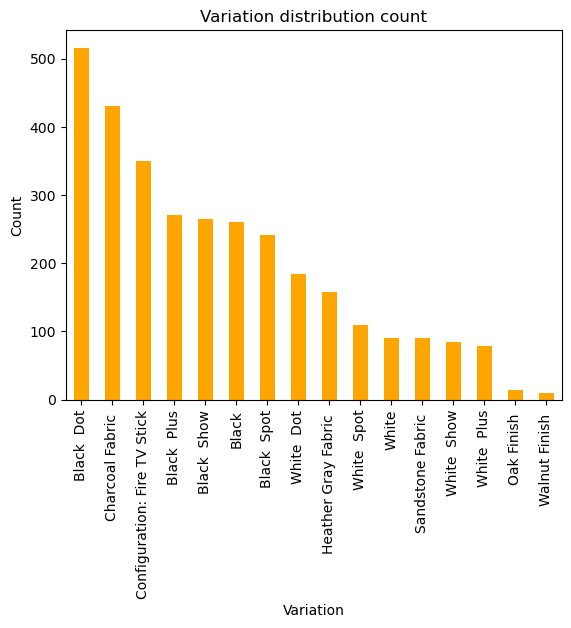

In [31]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

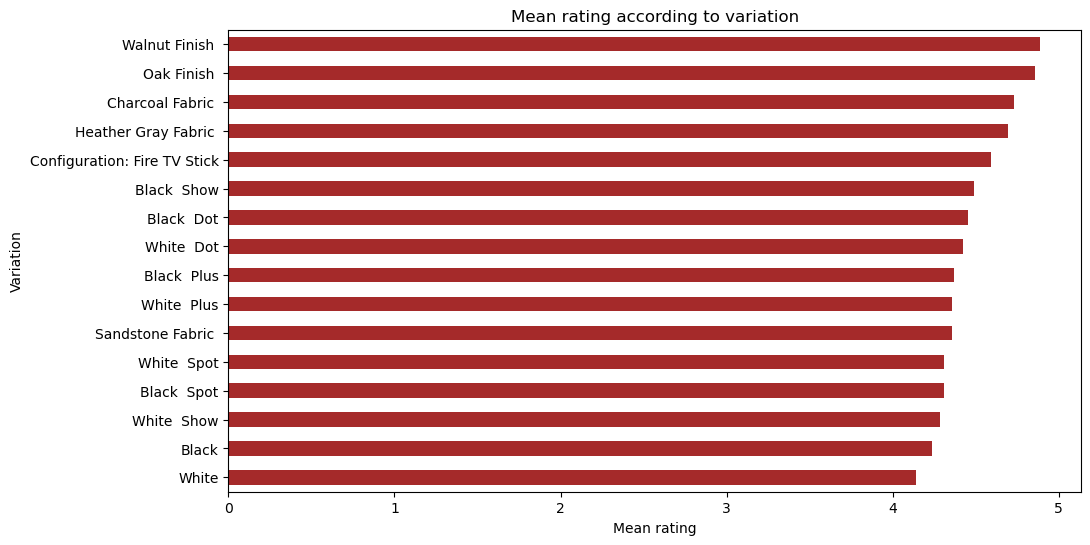

In [32]:
#pltting the mean ratings vs the variation and sorting it in decending order
data.groupby('variation')['rating'].mean().sort_values().plot.barh(color='brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Mean rating')
plt.ylabel('Variation')
plt.show()


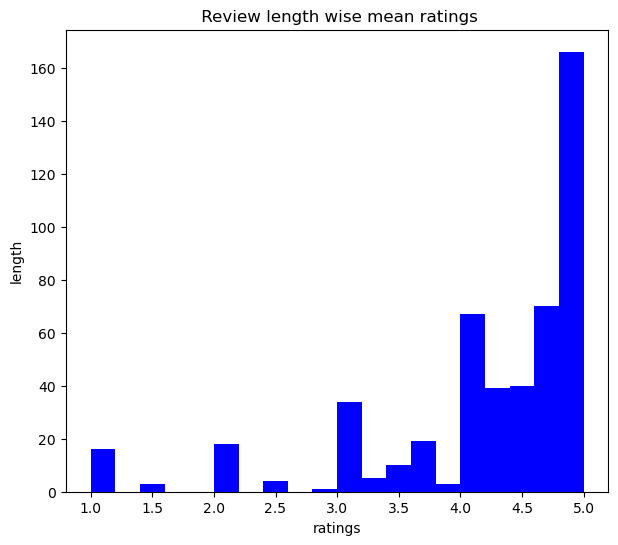

In [33]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [34]:
#we are taking the english stopwords and storing them in cv variable  and then fitting it into our dataset
# this step filters all the stop words from the reviews column
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)


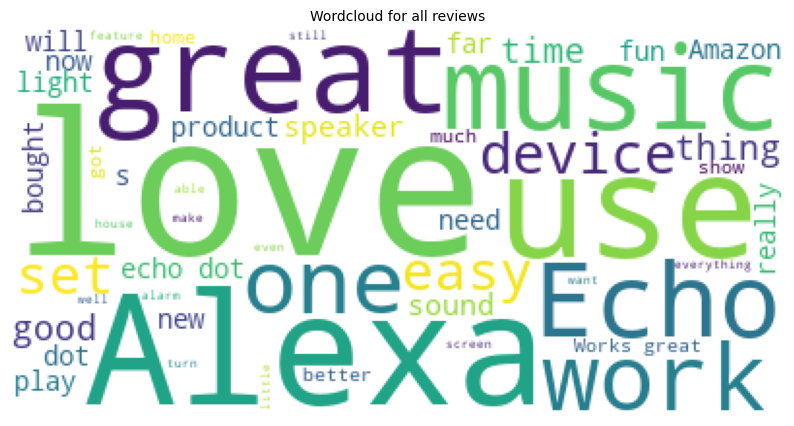

In [35]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [36]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


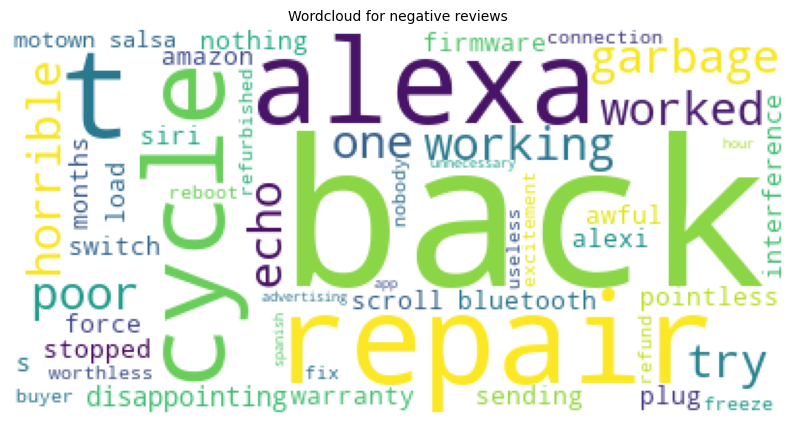

In [37]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

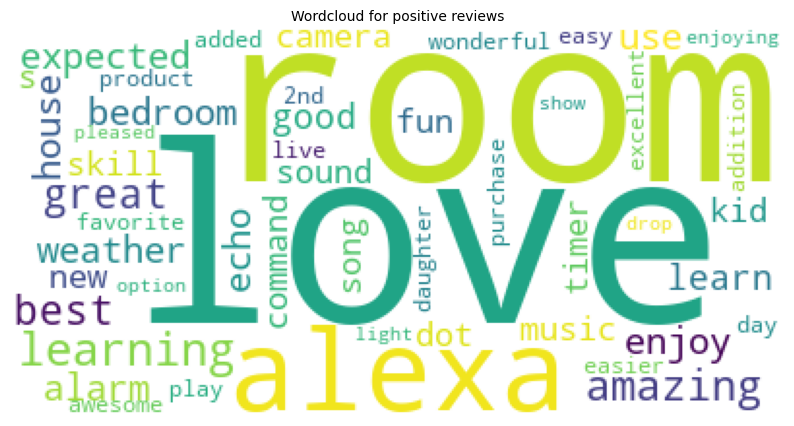

In [38]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

In [39]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [40]:
#vectorization process: where each of the sentences in corpus(paragraphs) are converted into 0's and 1's its
#prebuit in sklearn library.
#we are using bag of words to do the vectorization
cv = CountVectorizer(max_features = 2500) #here we are considering to take the top 2500 features
#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values


In [41]:
import os
os.makedirs('Models', exist_ok=True)
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [42]:
print(f"X shape: {X.shape}") #here the rows of x are the noof sentences in the reviews and columns 
#are noof features(top 2500 words) which we got during vectorization using bag of words 

print(f"y shape: {y.shape}")

X shape: (3150, 2500)
y shape: (3150,)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2205, 2500)
y train: (2205,)
X test: (945, 2500)
y test: (945,)


In [44]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")
print(X_train[:5])  # Print the first 5 rows of the array


X train max value: 12
X test max value: 10
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [45]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [46]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [47]:
#Predicting on the test set
y_preds_rf = model_rf.predict(X_test)

In [48]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds_rf)

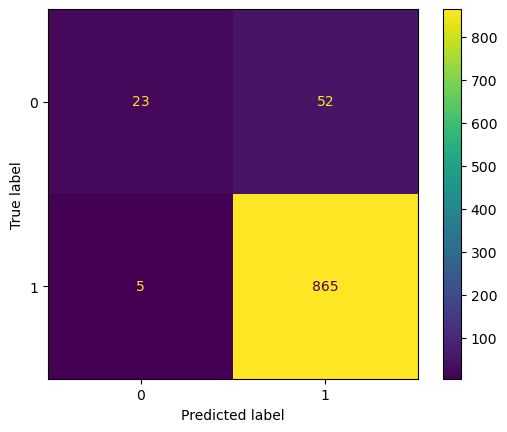

In [49]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

Training Accuracy RF : 0.9941043083900227
Accuracy for random forest: 0.9396825396825397


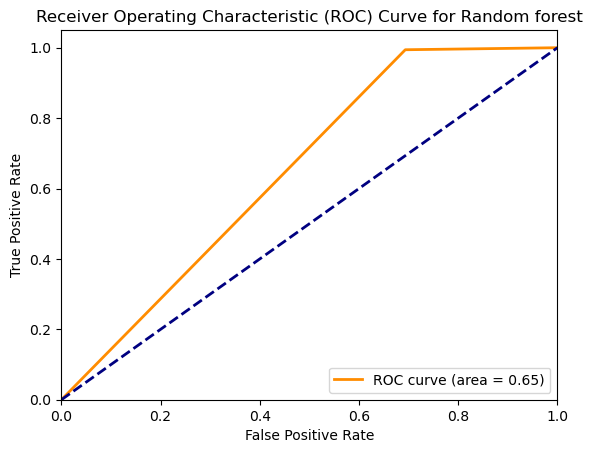

In [50]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt


# Calculate accuracy
print("Training Accuracy RF :", model_rf.score(X_train, y_train))
accuracy_rf = accuracy_score(y_test, y_preds_rf)
train_accuracy_rf=model_rf.score(X_train, y_train)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_preds_rf)
roc_auc = auc(fpr, tpr)

print("Accuracy for random forest:", accuracy_rf)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random forest')
plt.legend(loc="lower right")
plt.show()




In [51]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [52]:
y_preds_xgb = model_xgb.predict(X_test)

In [53]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds_xgb)
print(cm)

[[ 27  48]
 [  8 862]]


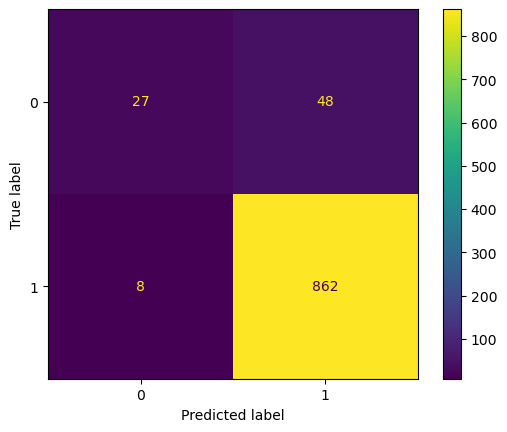

In [54]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

Training Accuracy_xgb : 0.9700680272108844
Accuracy for XGBoost: 0.9407407407407408


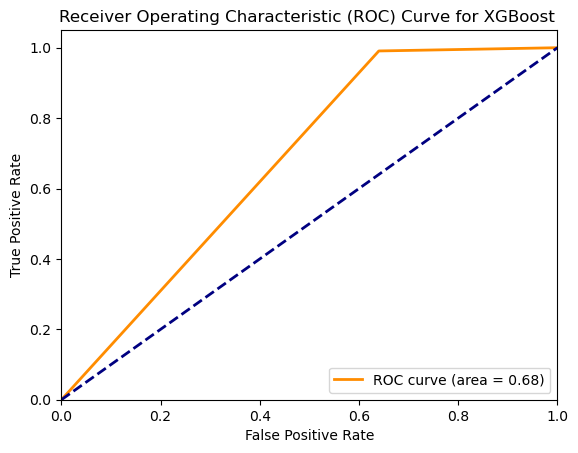

In [55]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

# Calculate accuracy
print("Training Accuracy_xgb :", model_xgb.score(X_train, y_train))
accuracy_xgb = accuracy_score(y_test, y_preds_xgb)
train_accuracy_xgb=model_xgb.score(X_train, y_train)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_preds_xgb)
roc_auc = auc(fpr, tpr)

print("Accuracy for XGBoost:", accuracy_xgb)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost ')
plt.legend(loc="lower right")
plt.show()

In [56]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

In [57]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
model_dt

DecisionTreeClassifier()

In [58]:
y_preds_dt = model_dt.predict(X_test)

In [59]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds_dt)
print(cm)

[[ 30  45]
 [ 40 830]]


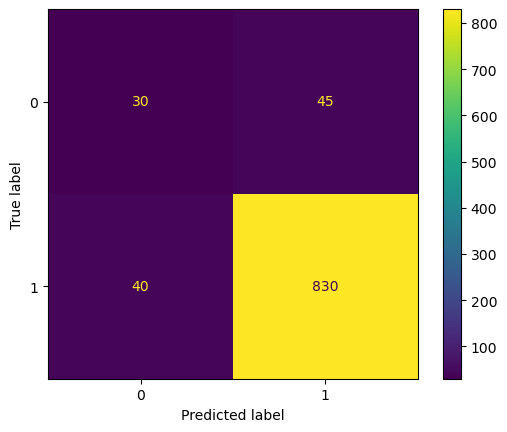

In [60]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

Training Accuracy _dt: 0.9941043083900227
Accuracy for decision tree: 0.91005291005291


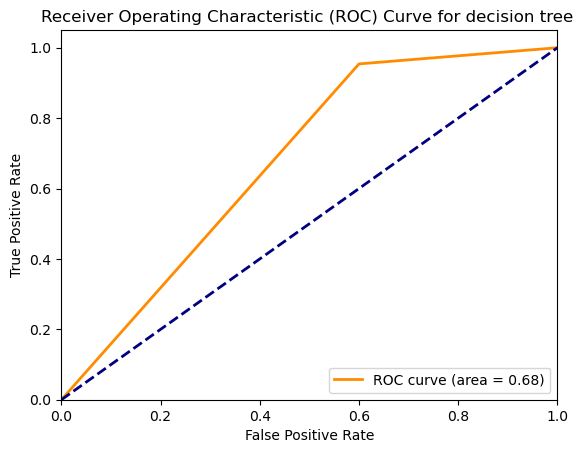

In [61]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

# Calculate accuracy
print("Training Accuracy _dt:", model_dt.score(X_train, y_train))
accuracy_dt = accuracy_score(y_test, y_preds_dt)
train_accuracy_dt=model_dt.score(X_train, y_train)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_preds_dt)
roc_auc = auc(fpr, tpr)

print("Accuracy for decision tree:", accuracy_dt)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for decision tree ')
plt.legend(loc="lower right")
plt.show()

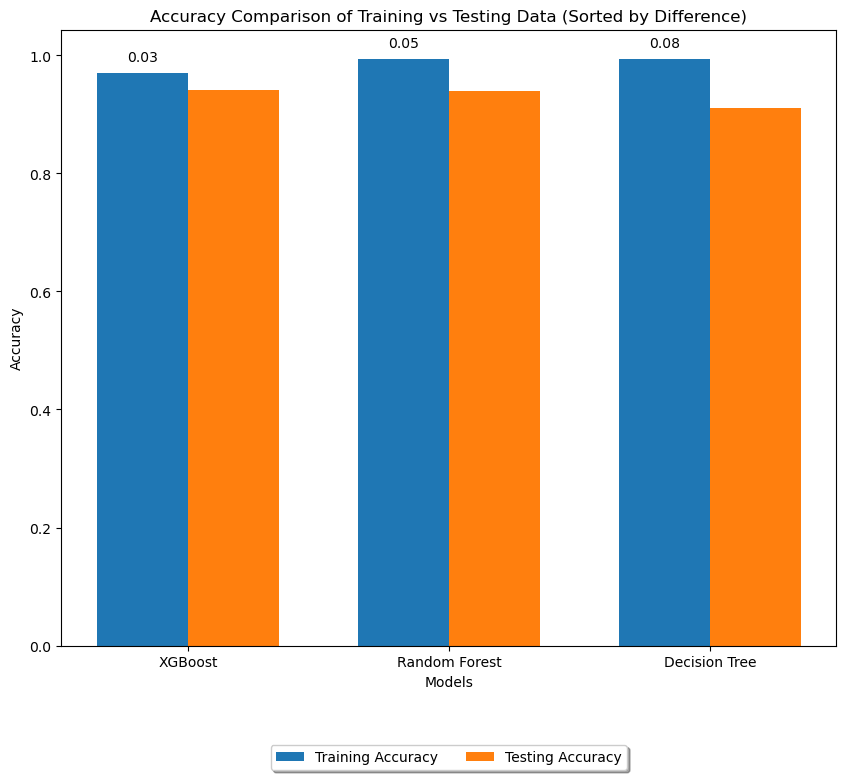

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Define models and their respective accuracy scores
models = ['Random Forest', 'XGBoost', 'Decision Tree']
train_accuracy = [train_accuracy_rf, train_accuracy_xgb, train_accuracy_dt]
test_accuracy = [accuracy_rf, accuracy_xgb, accuracy_dt]

# Calculate absolute differences between training and testing accuracies
diff_accuracies = [abs(train - test) for train, test in zip(train_accuracy, test_accuracy)]

# Sort models based on absolute differences
sorted_indices = np.argsort(diff_accuracies)
sorted_models = [models[i] for i in sorted_indices]
sorted_train_accuracy = [train_accuracy[i] for i in sorted_indices]
sorted_test_accuracy = [test_accuracy[i] for i in sorted_indices]

# Define the x-axis positions for the bars
x = np.arange(len(models))

# Define bar width
width = 0.35

# Set the size of the figure
plt.figure(figsize=(10, 8))

# Plot bars for training accuracy
train_bars = plt.bar(x - width/2, sorted_train_accuracy, width, label='Training Accuracy')

# Plot bars for testing accuracy
test_bars = plt.bar(x + width/2, sorted_test_accuracy, width, label='Testing Accuracy')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Training vs Testing Data (Sorted by Difference)')
plt.xticks(x, sorted_models)

# Add annotations for the difference in accuracies
for train_bar, test_bar in zip(train_bars, test_bars):
    height = max(train_bar.get_height(), test_bar.get_height())
    diff = abs(train_bar.get_height() - test_bar.get_height())
    plt.text(train_bar.get_x() + train_bar.get_width()/2, height + 0.02, f'{diff:.2f}', ha='center')

# Plot legend at the bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

# Show plot
plt.show()


Training Accuracy Decision Tree: 0.9941043083900227
Training Accuracy XGBoost: 0.9700680272108844
Training Accuracy Random Forest: 0.9941043083900227


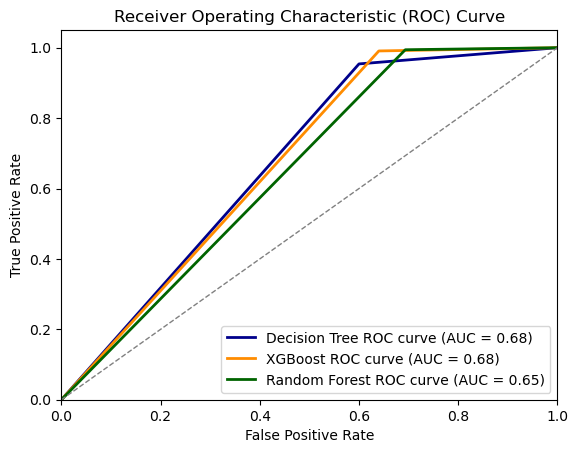

In [63]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

# Calculate accuracy for decision tree
print("Training Accuracy Decision Tree:", model_dt.score(X_train, y_train))
accuracy_dt = accuracy_score(y_test, y_preds_dt)
train_accuracy_dt = model_dt.score(X_train, y_train)

# Calculate ROC curve and AUC for decision tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_preds_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Calculate accuracy for XGBoost
print("Training Accuracy XGBoost:", model_xgb.score(X_train, y_train))
accuracy_xgb = accuracy_score(y_test, y_preds_xgb)
train_accuracy_xgb = model_xgb.score(X_train, y_train)

# Calculate ROC curve and AUC for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_preds_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Calculate accuracy for random forest
print("Training Accuracy Random Forest:", model_rf.score(X_train, y_train))
accuracy_rf = accuracy_score(y_test, y_preds_rf)
train_accuracy_rf = model_rf.score(X_train, y_train)

# Calculate ROC curve and AUC for random forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_preds_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves for all models
plt.figure()

# Plot ROC curve for decision tree
plt.plot(fpr_dt, tpr_dt, color='darkblue', lw=2, label='Decision Tree ROC curve (AUC = %0.2f)' % roc_auc_dt)

# Plot ROC curve for XGBoost
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='XGBoost ROC curve (AUC = %0.2f)' % roc_auc_xgb)

# Plot ROC curve for random forest
plt.plot(fpr_rf, tpr_rf, color='darkgreen', lw=2, label='Random Forest ROC curve (AUC = %0.2f)' % roc_auc_rf)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
